## Section Two: Deep Learning - Semantic Segmentation on Sentinel-2 Imagery
In this section, you will implement a pipeline that performs semantic segmentation on Sentinel-2
imagery using a pretrained model. At this stage, we want to perform basic segmentation on 3 or
so classes: Water, Vegetation and Buildings.

#### Objective:
Given:
- An AOI (given as GeoJSON).
- A target date (You may select any date within the last 5 years)

Your task is to:
- Download the Sentinel-2 data for the target date for that AOI. If data is unavailable for
the target date, retrieve data for the closest available date.
- Select a pretrained model suited to this task. Important: Explain why you picked this
model. Don’t hesitate to go into detail here, on the training dataset used, the
performance metrics, tradeoffs etc. We intentionally did not preselect a model, as we
want to assess and understand your model selection process. This is a key skill we will
be looking at.
- Process the data to the right format for the model
- Output predictions for our AOI and target date using the selected model. We do not
expect a specific output type, just the one outputted by the model (csv, GeoTIFF, png).
You are expected to submit the output along with your code.

#### Notes:
- You may use either PyTorch or Tensorflow.
- If the AOI generates too large of a GeoTIFF for reasonable inference times, you are
allowed to reduce the area accordingly.
- In this section, **you are not expected to fine-tune the model**, but use it as is.

In [13]:
import json
from datetime import datetime
import matplotlib.pyplot as plt

### Définition des paramètres

In [ ]:
target_date = datetime(2022, 8, 30).strftime("%Y-%m-%d")
cloud_cover_limit = 20

AOI_path = '../AOI_Rubicon.geojson'
with open(AOI_path, 'r') as file:
    geojson_data = json.load(file)["features"][0]["geometry"]

### Génération des pngs pour la date voulue

In [15]:
from rubicon_cs.main import png_for_target_date

#use rgb_optimized for Sentinel-2 L2A True Color Optimized from https://custom-scripts.sentinel-hub.com/sentinel-2/l2a_optimized/ or rgb for raw colors but needs postprocessing like brightening up
date = png_for_target_date(AOI=geojson_data, target_date=target_date, cloud_cover_limit=cloud_cover_limit, rgb_evalscript='rgb_optimized')

Using nearest available date: 2022-09-01
Saved RGB image for 2022-09-01 to rgb_2022-09-01.png


### Affichage de l'image récupérée sur sentinel-hub

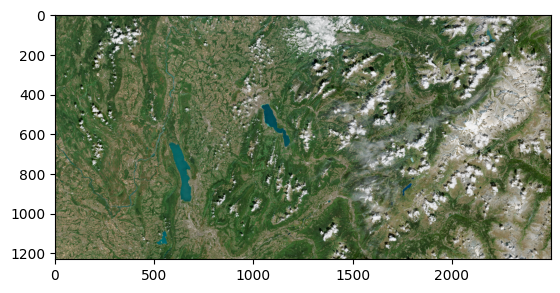

In [19]:
from PIL import Image
import torchvision.transforms.functional as TF

img_path = f"rgb_{date}.png"
image = Image.open(img_path).convert('RGB')

plt.imshow(image)
plt.show()

### Téléchargement et choix de l’architecture du modèle

Dans ce projet, j’ai utilisé le modèle **`Satlas_RGB2_epoch100.pth`**, dont les poids sont disponibles sur [Hugging Face](https://huggingface.co/martinkorelic/dpr-zoo-models/tree/main).

#### 🔍 Choix du modèle

J’ai passé pas mal de temps à identifier un modèle adapté à notre cas d’usage. Voici les critères qui ont guidé mon choix :

- **Type de modèle** : je recherchais un modèle de segmentation sémantique (type UNet, DeepLabV3, etc.).
- **Dataset d'entraînement** : idéalement un modèle pré-entraîné sur des images satellites proches de Sentinel-2, et sur un dataset suffisamment large.  
  Par exemple, les datasets comme *Amazon* ou *Atlantic Forest* (~500 images) me paraissaient limités, notamment pour les paysages montagneux de notre zone d’étude.  
  À l’inverse, **Satlas Pretrain** couvre une grande partie de la planète (30TB de données), avec une amélioration d'accuracy notable par rapport à d'autres datasets généralistes comme *ImageNet* ou *BigEarthNet*.  
  👉 Voir les courbes comparatives ici : [satlas-pretrain.allen.ai](https://satlas-pretrain.allen.ai/).
- **Nombre de classes** : un modèle avec un nombre de classes similaire ou facilement réductible à des catégories simples comme *eau / végétation / urbain*.

#### 🧪 Alternatives envisagées

J’ai exploré plusieurs modèles pré-entraînés, notamment via **TorchGeo**, TensorFlowHub, HuggingFace mais beaucoup étaient axés sur la classification.  
L’idéal aurait été de pouvoir réutiliser facilement un backbone, remplacer la tête par une segmentation sémantique, puis faire un fine-tuning léger (c’est l’objet de la section 3).  
Cependant, sans fine-tuning, la tête de segmentation initialisée aléatoirement produirait des résultats dénués de sens.

#### ✅ Modèle retenu

Finalement, j’ai trouvé sur Hugging Face un modèle pré-entraîné sur ~10 000 images du dataset **Satlas Pretrain**, avec des métriques très convaincantes :

- **F1-score** : 0.681  
- **Accuracy** : 0.95

Il utilise un **backbone Swin Transformer**, suivi d’un **FPN (Feature Pyramid Network)** et d’une **tête de prédiction**.  
👉L’architecture complète est disponible ici : [github.com/allenai/satlaspretrain_models](https://github.com/allenai/satlaspretrain_models/) et elle est directement récupérable grâce à la librairie satlaspretrain_models

#### 🧪 Test et perspectives

J’ai testé ici le modèle **RGB à 12 classes**. Avec un peu plus de temps, j’aurais aimé explorer les variantes :

- `Satlas_MS_tci-b08_epoch150`
- `Satlas_MS_tci-b08-b11-b12_epoch40`

Ces modèles sont entraînés sur les mêmes données mais avec **plus de bandes spectrales**, et affichent **des métriques légèrement meilleures**.

J'aurais également aimé prendre plus de temps pour explorer les modèles déjà existants et comparer différentes architectures comme UNet/DeepLabV3+

*Autres sources à la fin du notebook*

In [ ]:
import torch
import satlaspretrain_models

#If you have problems accessing gpu on colab or your device
# original_torch_load = torch.load

# def cpu_load(*args, **kwargs):
#     if 'map_location' not in kwargs:
#         kwargs['map_location'] = torch.device('cpu')
#     return original_torch_load(*args, **kwargs)

# torch.load = cpu_load

# Load model
weights_manager = satlaspretrain_models.Weights()
MODEL_CHECKPOINT_ID = "Sentinel2_SwinB_SI_RGB"
model = weights_manager.get_pretrained_model(
    MODEL_CHECKPOINT_ID,
    fpn=True,
    head=satlaspretrain_models.Head.SEGMENT,
    num_categories=12
)

### Application des weights pré-entrainés sur le dataset Satlas RGB

In [5]:
#If you don't have the model in models uncomment next line
# !wget "https://huggingface.co/martinkorelic/dpr-zoo-models/resolve/main/Satlas_RGB2_epoch100.pth" -O ../models/Satlas_RGB2_epoch100.pth

weights_path = "../models/Satlas_RGB2_epoch100.pth"  # Path to the downloaded .pth weights
weights = torch.load(weights_path, map_location=torch.device('cpu'))
model.load_state_dict(weights, strict=False)


# Set the model to evaluation mode (important for inference)
model.eval()

Model(
  (backbone): SwinBackbone(
    (backbone): SwinTransformer(
      (features): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (1): Sequential(
          (0): SwinTransformerBlockV2(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): ShiftedWindowAttentionV2(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (cpb_mlp): Sequential(
                (0): Linear(in_features=2, out_features=512, bias=True)
                (1): ReLU(inplace=True)
                (2): Linear(in_features=512, out_features=4, bias=False)
              )
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
            (norm2): LayerNorm((128,), eps=1e-05, element

### Découpage de l'image par patch et prédiction du modèle

In [ ]:
from rubicon_cs.main import semantic_segmentation_large_image

image_tensor = TF.to_tensor(image)  # shape: [3, H, W]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
patches_output = semantic_segmentation_large_image(image_tensor, model, device)

pred_mask = torch.argmax(patches_output, dim=0).numpy()  # [H, W]
print(pred_mask.shape)


/home/mathieujayet/.pyenv/versions/rubicon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Affichage du résultat avec toutes les classes du modèle pré-entrainé (12)

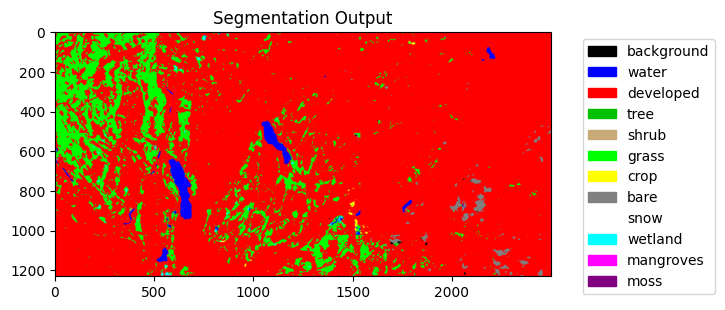

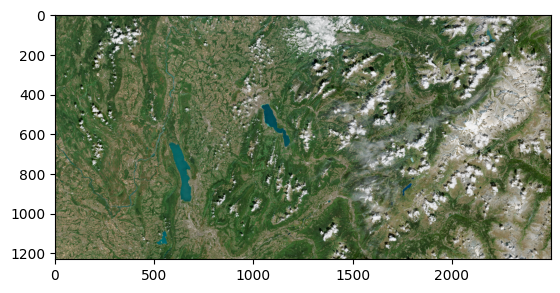

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Custom colormap
colormap = [
    [0, 0, 0],          # 0: background
    [0, 0, 255],        # 1: water
    [255, 0, 0],        # 2: developed
    [0, 192, 0],        # 3: tree
    [200, 170, 120],    # 4: shrub
    [0, 255, 0],        # 5: grass
    [255, 255, 0],      # 6: crop
    [128, 128, 128],    # 7: bare
    [255, 255, 255],    # 8: snow
    [0, 255, 255],      # 9: wetland
    [255, 0, 255],      # 10: mangroves
    [128, 0, 128]       # 11: moss
]

# Define the class labels
labels = [
    "background",
    "water",
    "developed",
    "tree",
    "shrub",
    "grass",
    "crop",
    "bare",
    "snow",
    "wetland",
    "mangroves",
    "moss"
]

# Convert predicted classes to RGB colors
mask_rgb = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)  # Shape: (512, 512, 3)

for i in range(12):  # 12 classes
    mask_rgb[pred_mask == i] = colormap[i]

plt.imshow(mask_rgb)
plt.title("Segmentation Output")

patches = [mpatches.Patch(color=np.array(colormap[i])/255, label=labels[i]) for i in range(len(labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

plt.imshow(image)
plt.show()

# If you need to save result uncomment next line
# Image.fromarray(mask_rgb).save(f"outputs/section_2/segmentation_mask_{date}.png")

### Affichage du résultat simplifié trois classes : Water/Vegetation/Urban (+Other)

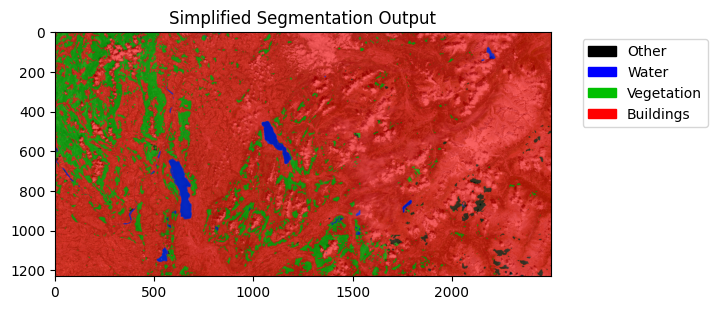

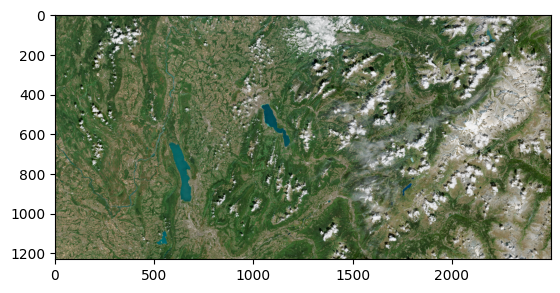

In [ ]:
# Simplified colormap
simplified_colormap = [
    [0, 0, 0],          # Other
    [0, 0, 255],        # Water
    [0, 192, 0],        # Vegetation
    [255, 0, 0],        # Buildings
]

# Simplified labels for the new categories
simplified_labels = [
    "Other",
    "Water",
    "Vegetation",
    "Buildings"
]

simplified_pred = np.zeros_like(pred_mask)

# Water: class 1 (water)
simplified_pred[pred_mask == 1] = 1
# Vegetation: classes 3, 4, 5, 6, 9, 10, 11 (tree, shrub, grass, crop, wetland, mangroves, moss)
simplified_pred[np.isin(pred_mask, [3, 4, 5, 6, 9, 10, 11])] = 2
# Buildings: classes 2 (developed)
simplified_pred[np.isin(pred_mask, [2])] = 3

# Convert simplified prediction to RGB mask
mask_rgb = np.zeros((simplified_pred.shape[0], simplified_pred.shape[1], 3), dtype=np.uint8)

# Loop over each simplified class (Other, Water, Vegetation, Buildings)
for i in range(4):  # 3 categories
    mask_rgb[simplified_pred == i] = simplified_colormap[i]

# Visualize the RGB segmentation mask
plt.imshow(mask_rgb, alpha = 1)
plt.title("Simplified Segmentation Output")

# Create a legend with the simplified class labels
patches = [mpatches.Patch(color=np.array(simplified_colormap[i])/255, label=simplified_labels[i]) for i in range(len(simplified_labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.imshow(image, alpha=0.4)
plt.show()

plt.imshow(image)
plt.show()

# If you need to save result uncomment next line
# Image.fromarray(mask_rgb).save(f"outputs/section_2/simplified_segmentation_mask_{date}.png")

### *Autres sources*

https://github.com/pavlo-seimskyi/semantic-segmentation-satellite-imagery

https://github.com/stolarinhoo/Sentinel-2-Satellite-Images-Semantic-Segmentation-with-U-NET_Deep-Learning-approach

https://www.mathworks.com/help/images/classify-land-cover-using-sentinel-2-multispectral-images.html

https://documentation.dataspace.copernicus.eu/APIs/openEO/openeo-community-examples/python/ParcelDelineation/Parcel%20delineation.html

https://torchgeo.readthedocs.io/en/latest/api/models.html#pretrained-weights

https://huggingface.co/odil111/yolov8m-seg-fine-tuned-on-spacenetv2/tree/main

https://huggingface.co/odil111/unet-fine-tuned-on-openearthmap/tree/main

https://huggingface.co/dcrey7/wetlands_segmentation_deeplabsv3plus/tree/main

https://huggingface.co/martinkorelic/dpr-zoo-models/tree/main

https://satlas-pretrain.allen.ai/